In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
churn_data = pd.read_excel('Churn_Data.xlsx')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


In [3]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [70]:
def create_churn_plot(column_name):
    
    grouped = churn_data.groupby([column_name, 'Churn']).size().unstack()

    grouped['Total'] = grouped['Yes'] + grouped['No']
    grouped['Percentage_Yes'] = (grouped['Yes'] / grouped['Total']) * 100
    grouped['Percentage_No'] = (grouped['No'] / grouped['Total']) * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    grouped[['Percentage_Yes', 'Percentage_No']].plot(kind='bar', ax=ax1)
    ax1.set_title(f'Churn by {column_name}')
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Percentage of Churn')

    for i in ax1.containers:
        ax1.bar_label(i, labels=[f"{val:.1f}%" for val in i.datavalues], label_type='edge', fontsize=10, padding=5)

    ax1.legend(['Yes', 'No'])
    
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    count = churn_data[column_name].value_counts()
    ax2.pie(count, labels=count.index, autopct='%1.1f%%', startangle=90)
    ax2.set_title(f'{column_name} Distribution')
    
    plt.show()

In [40]:
churn_data['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

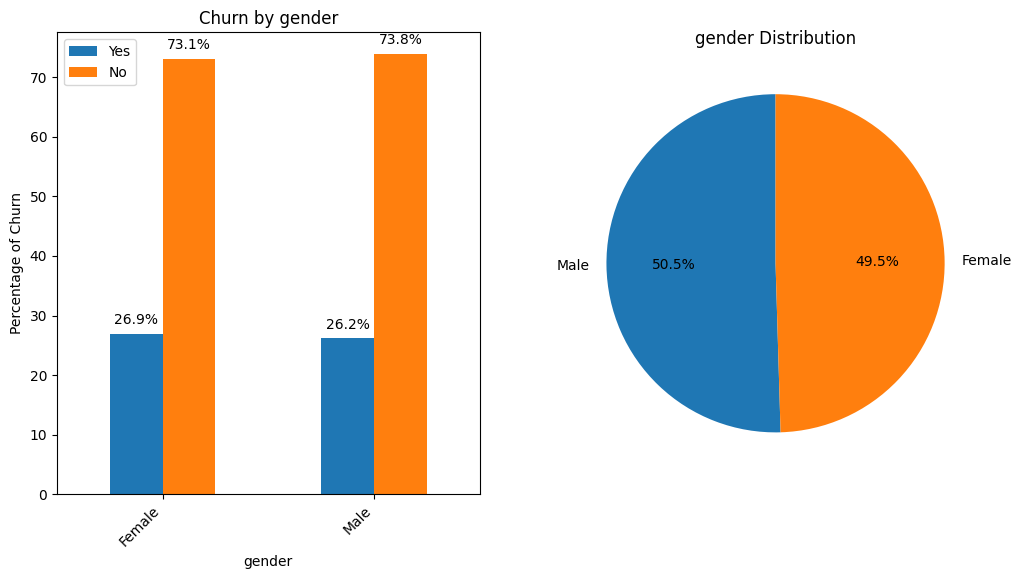

In [71]:
create_churn_plot('gender')

In [42]:
churn_data['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

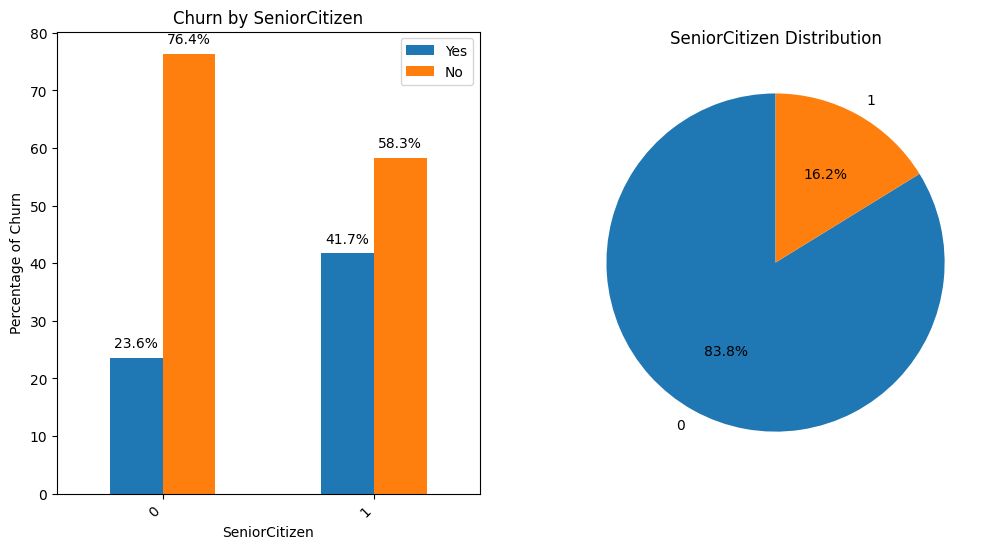

In [72]:
create_churn_plot('SeniorCitizen')

In [44]:
churn_data['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

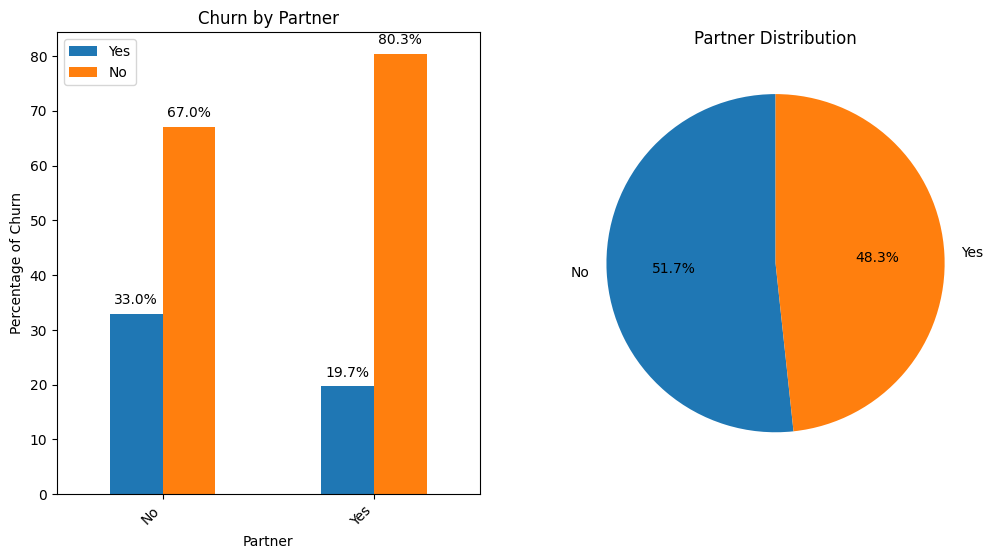

In [73]:
create_churn_plot('Partner')

In [46]:
churn_data['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

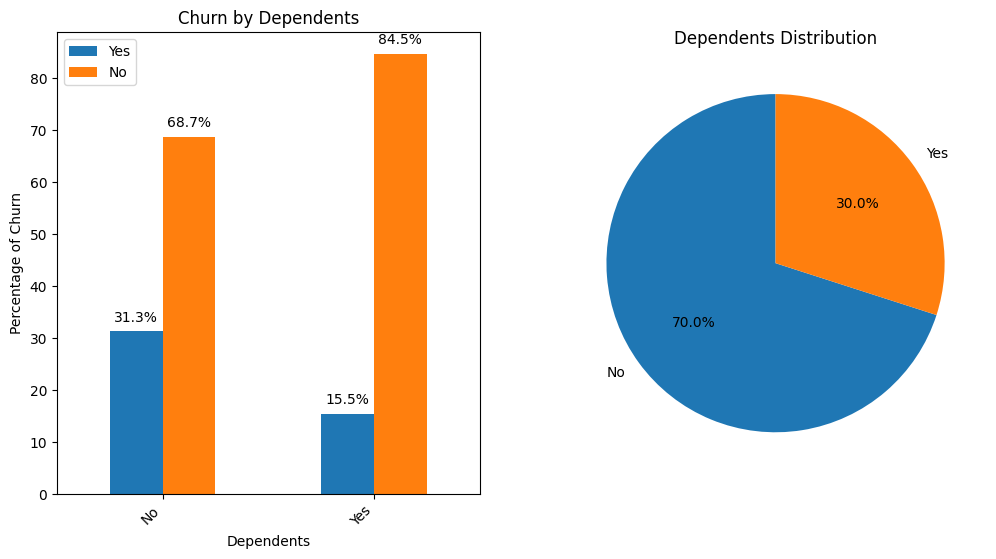

In [74]:
create_churn_plot('Dependents')

In [89]:
churn_data['PhoneService'].value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

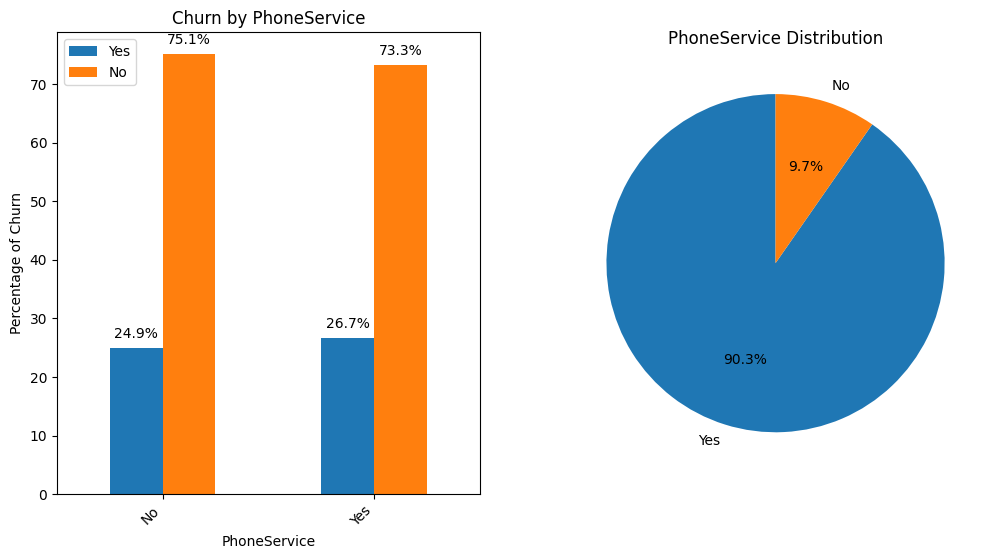

In [75]:
create_churn_plot('PhoneService')

In [90]:
churn_data['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

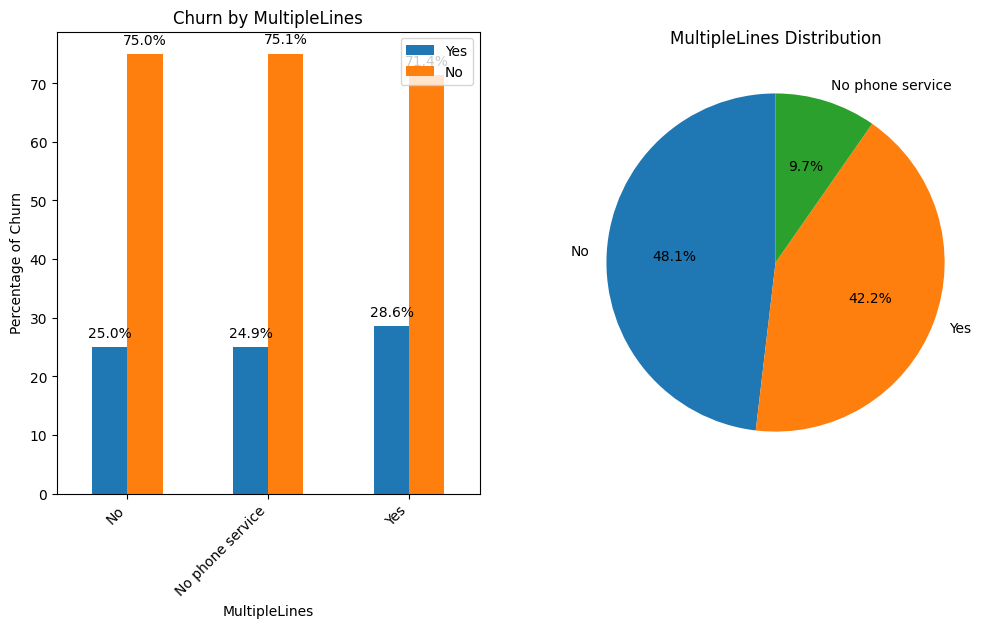

In [76]:
create_churn_plot('MultipleLines')

In [92]:
churn_data['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

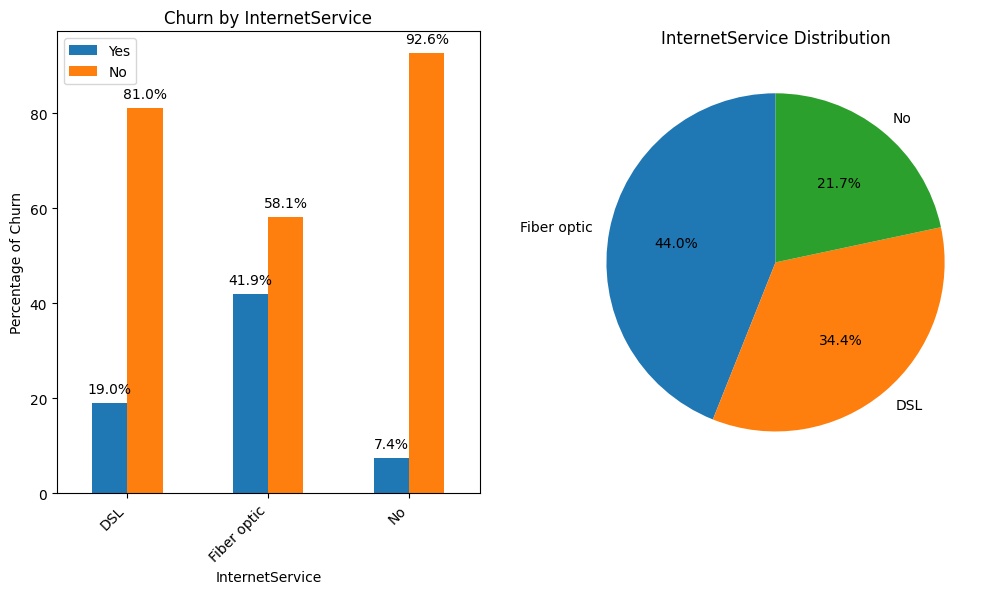

In [78]:
create_churn_plot('InternetService')

In [94]:
churn_data['OnlineSecurity'].value_counts()

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

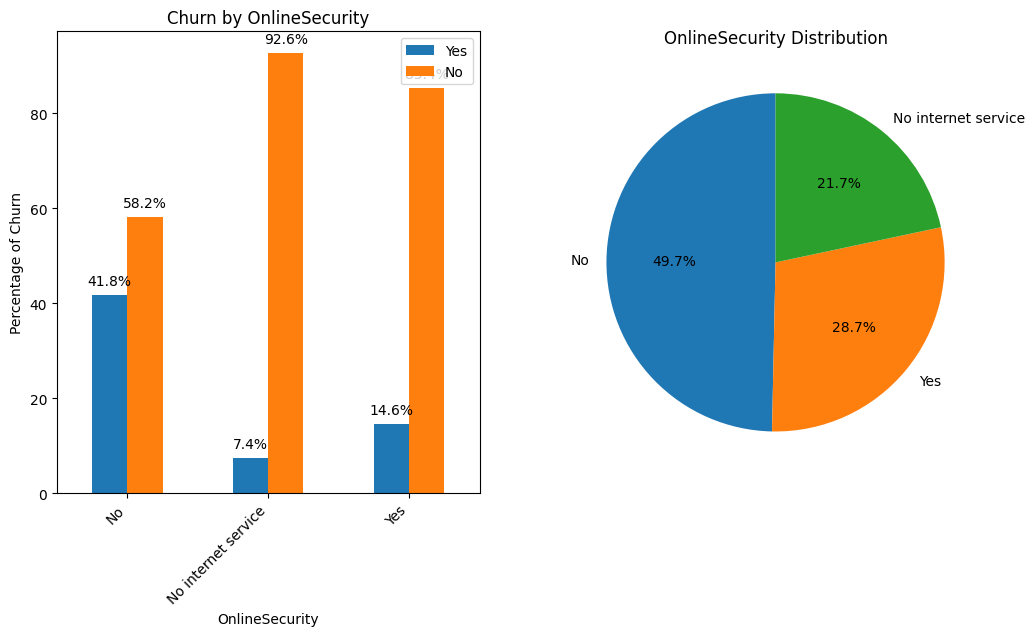

In [79]:
create_churn_plot('OnlineSecurity')

In [96]:
churn_data['OnlineBackup'].value_counts()

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

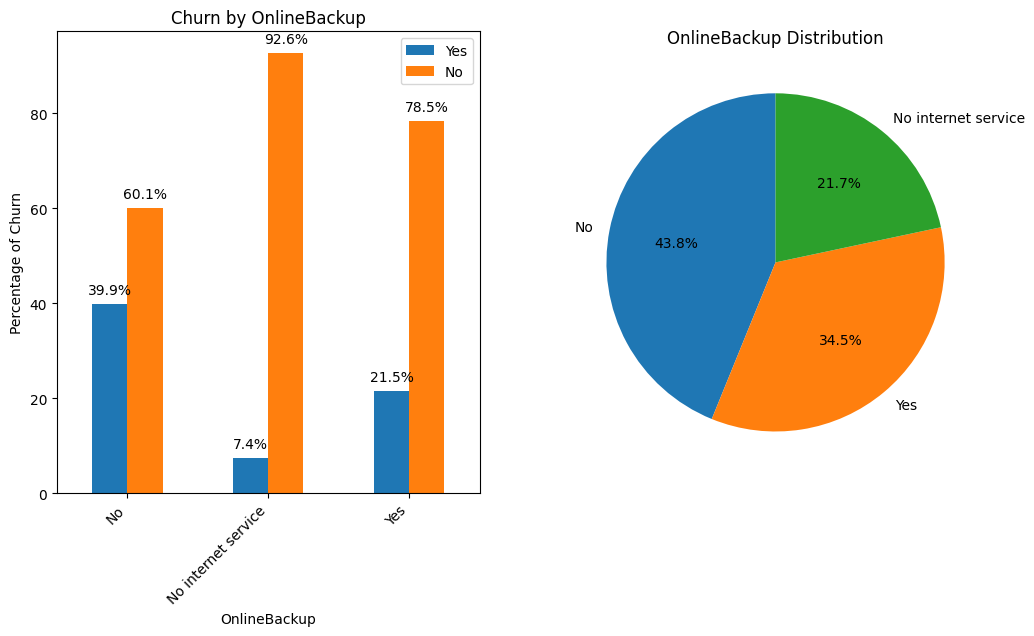

In [80]:
create_churn_plot('OnlineBackup')

In [97]:
churn_data['DeviceProtection'].value_counts()

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

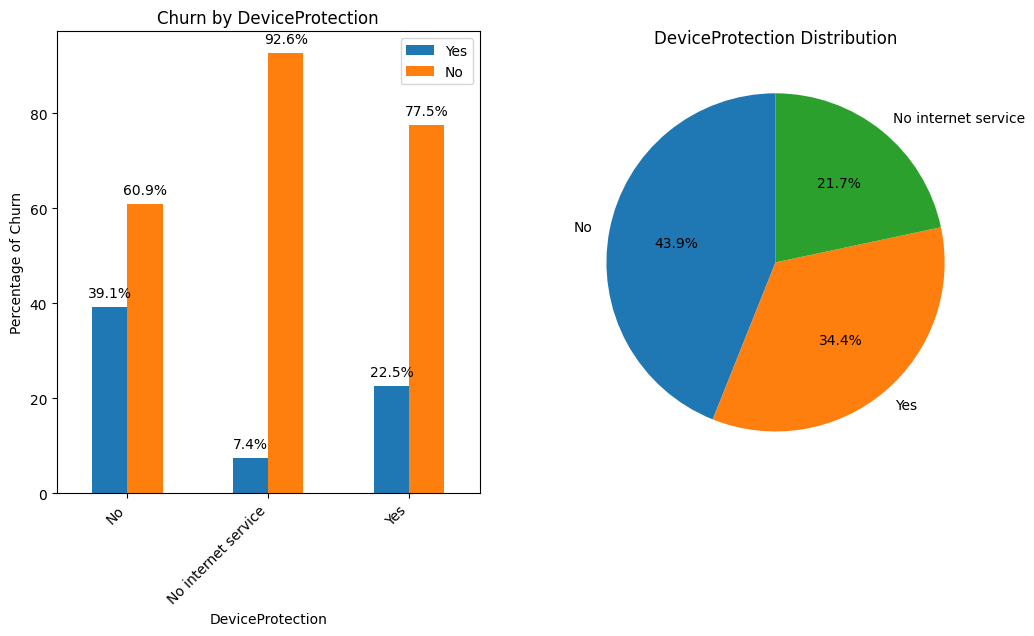

In [81]:
create_churn_plot('DeviceProtection')

In [98]:
churn_data['TechSupport'].value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

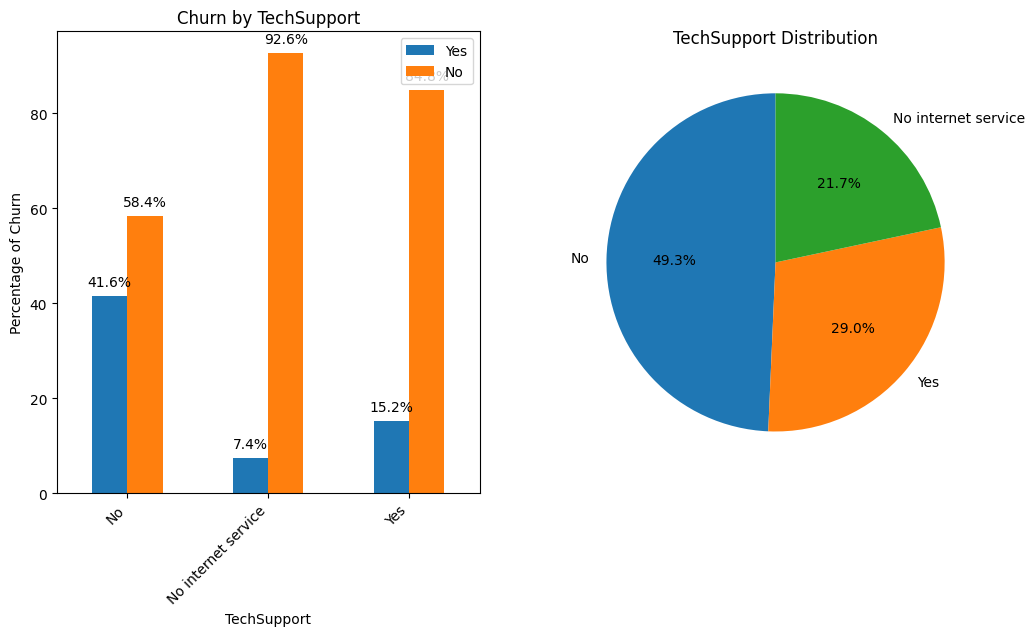

In [82]:
create_churn_plot('TechSupport')

In [99]:
churn_data['StreamingTV'].value_counts()

No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64

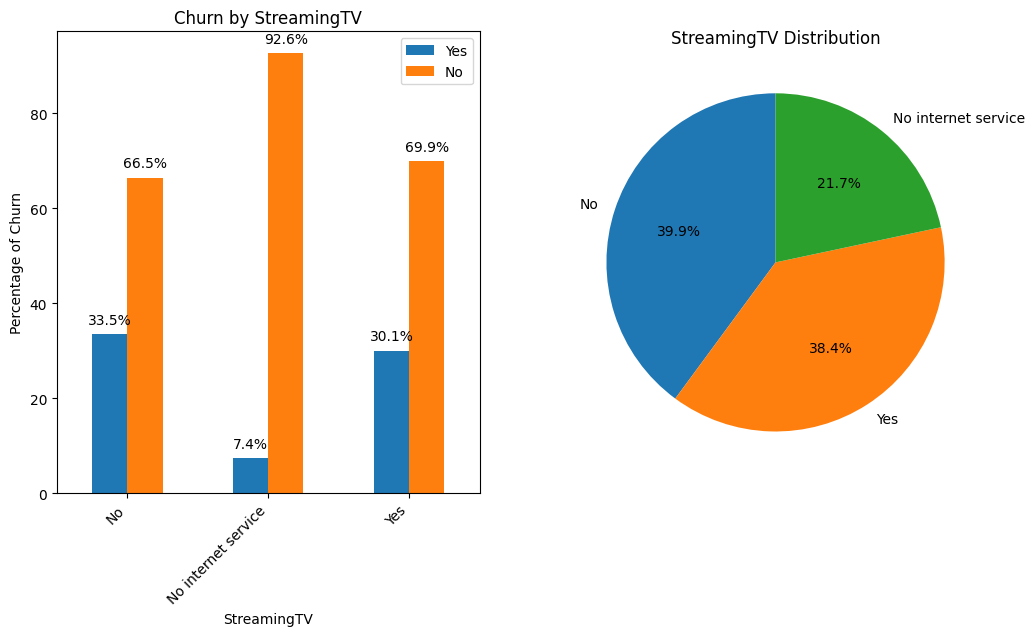

In [83]:
create_churn_plot('StreamingTV')

In [100]:
churn_data['StreamingMovies'].value_counts()

No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64

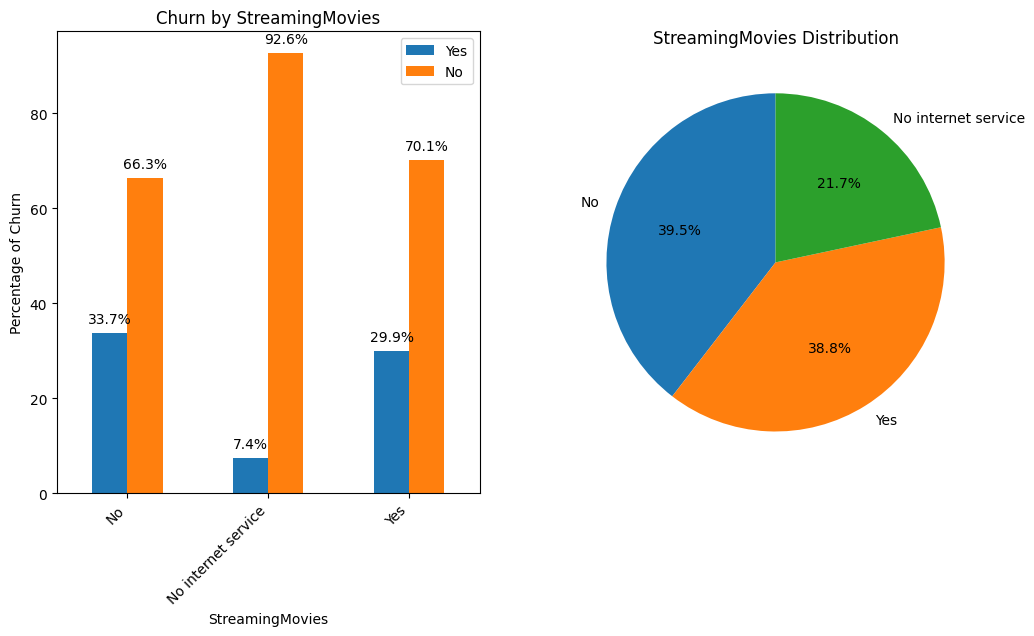

In [84]:
create_churn_plot('StreamingMovies')

In [101]:
churn_data['Contract'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

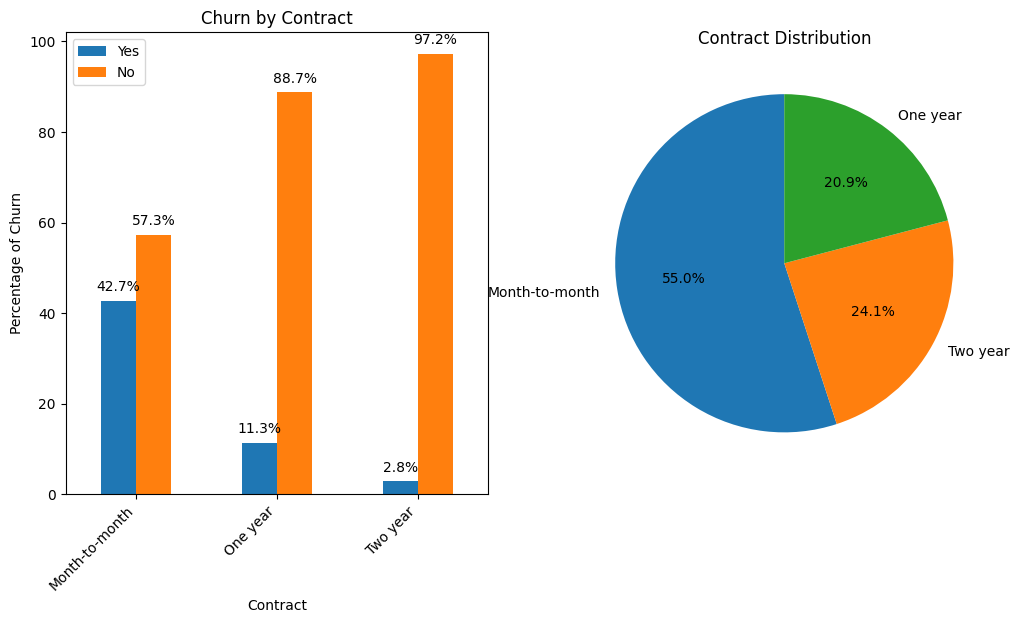

In [85]:
create_churn_plot('Contract')

In [102]:
churn_data['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

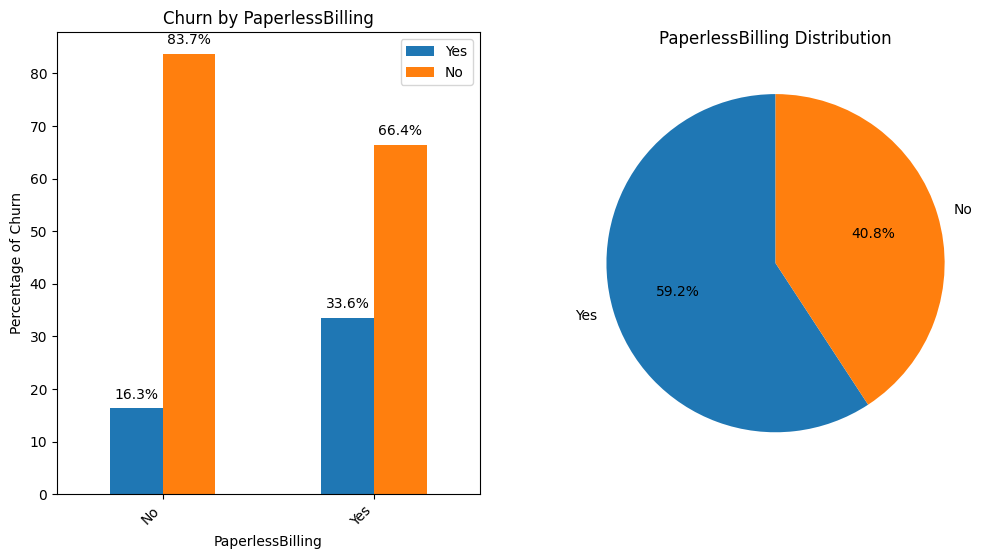

In [86]:
create_churn_plot('PaperlessBilling')

In [103]:
churn_data['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

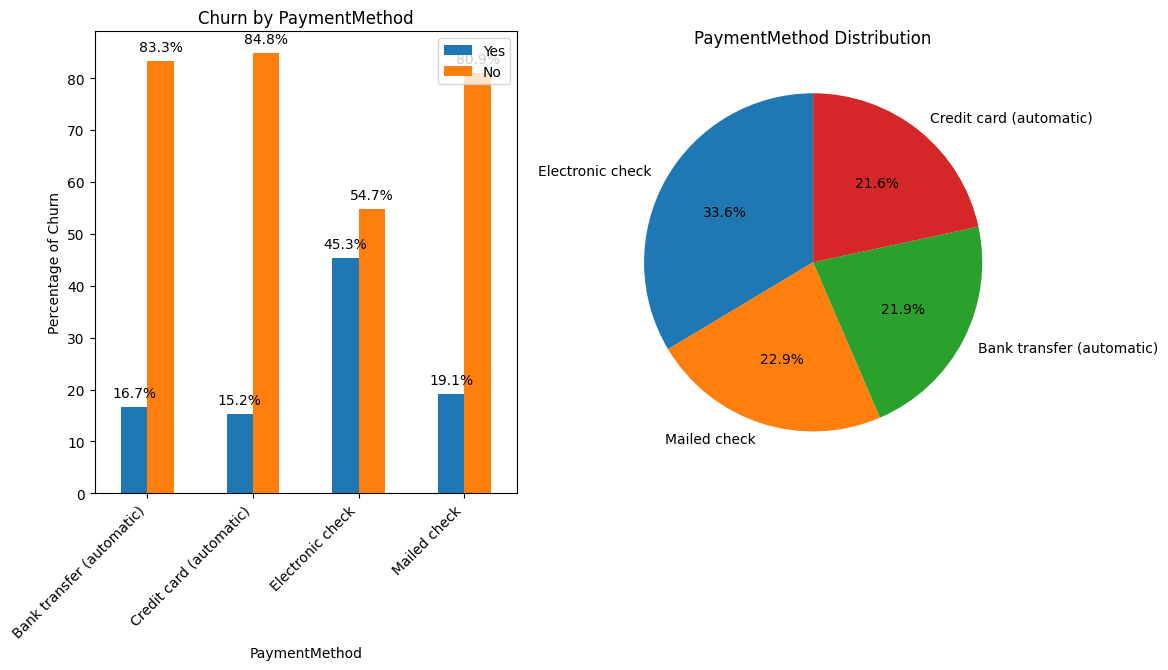

In [87]:
create_churn_plot('PaymentMethod')

In [108]:
def churn_numeric(column_name):
    sns.displot(data = churn_data, x = column_name, hue = 'Churn', kind='kde', fill=True, alpha=0.5)

    plt.title(f'Density Plot of {column_name} with respect to Churn')
    plt.xlabel(column_name)
    plt.ylabel('Density')

    plt.show()

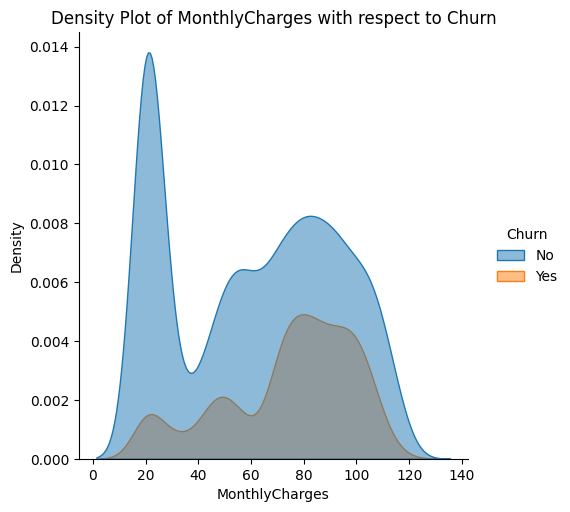

In [109]:
churn_numeric('MonthlyCharges')